# Survival Regression Model

@roman_avj
22 oct 2023

Generate a survival regression model to predict the time to event for each rent/ sell listing. This will be the baseline model. The idea is to use a gradient boosting survival model with *ipcwls* loss.

In [61]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from sklearn.pipeline import Pipeline, make_pipeline
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.linear_model import CoxPHSurvivalAnalysis
from scipy.integrate import simpson

# Data

In [42]:
df_model = pd.read_parquet("../../data/data2analyze_clean.parquet")

In [43]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94094 entries, 0 to 94093
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   marketplace                        94094 non-null  object        
 1   first_observed_date                94094 non-null  datetime64[us]
 2   last_observed_date                 94094 non-null  datetime64[us]
 3   time2event                         94094 non-null  int32         
 4   event                              94094 non-null  int64         
 5   id_sepomex                         94094 non-null  object        
 6   listing_type                       94094 non-null  object        
 7   property_type                      94094 non-null  object        
 8   is_development                     94094 non-null  int64         
 9   is_exterior                        94094 non-null  float64       
 10  is_penthouse                      

# Cox Model

## Pipe of Data

In [47]:
# select columns
vars_x_names = [
    'listing_type', 'property_type', 
    # bins
    'bin_group_marketplace', 'bin_group_seller', 'bin_group_id_sepomex',
    # numerical
    'prediction_price', 'surface_total', 'num_bathrooms', 'is_new_property_prob',
    'page_on_marketplace', 'available_secondary', 'anual_inflation', 'pnea', 'diff_first_prediction',
    # binary
    'is_exterior', 'is_penthouse'
]

# get y data as sksurv need
data_y = np.array(
    list(zip(df_model['event'], df_model['time2event'])),
    dtype=[('Status', '?'), ('Survival_in_days', '<f8')]
)

# get x data
data_x = (
    df_model.copy()
    .assign(prediction_price=lambda x: x['prediction_price'].div(1e+6))
    .astype({col: 'category' for col in ['listing_type', 'property_type', 'bin_group_marketplace', 'bin_group_seller', 'bin_group_id_sepomex']})
    .astype({col: np.float64 for col in [
        'prediction_price', 'surface_total', 'num_bathrooms', 'is_new_property_prob',
        'page_on_marketplace', 'available_secondary', 'anual_inflation', 'pnea', 'diff_first_prediction']})
    .astype({col: np.int8 for col in ['is_exterior', 'is_penthouse']})
    [vars_x_names]
)
data_x.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94094 entries, 0 to 94093
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   listing_type           94094 non-null  category
 1   property_type          94094 non-null  category
 2   bin_group_marketplace  94094 non-null  category
 3   bin_group_seller       94094 non-null  category
 4   bin_group_id_sepomex   94094 non-null  category
 5   prediction_price       94094 non-null  float64 
 6   surface_total          94094 non-null  float64 
 7   num_bathrooms          94094 non-null  float64 
 8   is_new_property_prob   94094 non-null  float64 
 9   page_on_marketplace    94094 non-null  float64 
 10  available_secondary    94094 non-null  float64 
 11  anual_inflation        94094 non-null  float64 
 12  pnea                   94094 non-null  float64 
 13  diff_first_prediction  94094 non-null  float64 
 14  is_exterior            94094 non-null 

In [50]:
# one hot encode
data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.info()

colnames_x_numeric = data_x_numeric.columns
data_x_numeric = data_x_numeric.to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94094 entries, 0 to 94093
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   listing_type=for-sale          94094 non-null  float64
 1   property_type=house            94094 non-null  float64
 2   bin_group_marketplace=group_1  94094 non-null  float64
 3   bin_group_marketplace=group_2  94094 non-null  float64
 4   bin_group_seller=group_1       94094 non-null  float64
 5   bin_group_seller=group_2       94094 non-null  float64
 6   bin_group_seller=group_3       94094 non-null  float64
 7   bin_group_seller=group_4       94094 non-null  float64
 8   bin_group_id_sepomex=group_1   94094 non-null  float64
 9   bin_group_id_sepomex=group_2   94094 non-null  float64
 10  bin_group_id_sepomex=group_3   94094 non-null  float64
 11  bin_group_id_sepomex=group_4   94094 non-null  float64
 12  prediction_price               94094 non-null 

In [51]:
# boxcox
location_cols_boxcox = [colnames_x_numeric.get_loc(col) 
                   for col in ['prediction_price', 'surface_total', 'page_on_marketplace']]

data_x_numeric_aux = data_x_numeric[:, location_cols_boxcox] / 1e+6
data_x_numeric_aux = PowerTransformer(method='box-cox', standardize=True).fit_transform(data_x_numeric_aux)
data_x_numeric[:,location_cols_boxcox] = data_x_numeric_aux

In [52]:
# scale
location_cols_scale = [colnames_x_numeric.get_loc(col) 
                   for col in ['num_bathrooms', 'is_new_property_prob',  'available_secondary', 'anual_inflation', 'pnea', 'diff_first_prediction']]
data_x_numeric_aux = data_x_numeric[:, location_cols_scale]
data_x_numeric_aux = StandardScaler().fit_transform(data_x_numeric_aux)
data_x_numeric[:,location_cols_scale] = data_x_numeric_aux

In [53]:
# split train & test
X_train, X_test, y_train, y_test = train_test_split(
    data_x_numeric, data_y, test_size=0.2, random_state=42, stratify=data_y['Status']
)

## Train

In [54]:
# train cox
coxph_all = CoxPHSurvivalAnalysis()
coxph_all.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

In [55]:
# look params
pd.Series(coxph_all.coef_, index=colnames_x_numeric).sort_values()

pnea                            -0.672453
listing_type=for-sale           -0.659732
anual_inflation                 -0.239155
surface_total                   -0.083986
diff_first_prediction           -0.079721
page_on_marketplace             -0.073400
prediction_price                -0.048679
property_type=house             -0.028820
is_new_property_prob            -0.017473
num_bathrooms                   -0.002264
is_penthouse                     0.003354
available_secondary              0.006418
is_exterior                      0.060334
bin_group_id_sepomex=group_1     0.170382
bin_group_id_sepomex=group_2     0.236616
bin_group_id_sepomex=group_3     0.309848
bin_group_seller=group_1         0.344360
bin_group_id_sepomex=group_4     0.452809
bin_group_seller=group_2         0.643097
bin_group_marketplace=group_1    0.737957
bin_group_marketplace=group_2    0.756822
bin_group_seller=group_3         0.949131
bin_group_seller=group_4         1.429285
dtype: float64

### Metrics

In [56]:
# concordance index
cindex_train = concordance_index_censored(y_train['Status'], y_train['Survival_in_days'], coxph_all.predict(X_train))
print('C-index train: {:.3f}'.format(cindex_train[0]))

C-index train: 0.735


In [59]:
# time to eval
va_times = np.linspace(10, 450, 30)

# get integrated brier score
cph_surv_prob = np.row_stack([fn(va_times) for fn in coxph_all.predict_survival_function(X_train)])

# brier score
ibs = integrated_brier_score(y_train, y_train, cph_surv_prob, va_times)
print('IBS: {:.3f}'.format(ibs))

IBS: 0.083


In [62]:
def get_mean_time(X, model, t0=0, tn=100):
    """Get mean time to event for a given time interval."""
    delta = np.linspace(t0, tn, 1000)
    surv_probas = np.row_stack([fn(delta) for fn in model.predict_survival_function(X)])

    # for each row, compute the area under the curve
    mean_time = np.array([simpson(y=y, x=delta) for y in surv_probas])
    return(mean_time)

def get_observed(X, y):
    # get observed time
    yobs = y[y['Status']]['Survival_in_days']

    # get observed rows
    Xobs = X[y['Status']]

    return Xobs, yobs

# predict mean time
Xobs, yobs = get_observed(X_train, y_train)
mean_time = get_mean_time(Xobs, coxph_all, t0=0, tn=488)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 55.030
MAPE: 1.385


<Axes: >

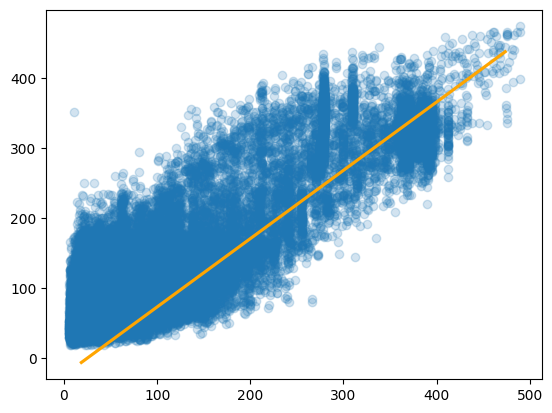

In [63]:
# look observed vs predicted
plt.scatter(yobs, mean_time, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange')

## Test

In [64]:
# concordance index
cindex_test = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], coxph_all.predict(X_test))
print('C-index test: {:.3f}'.format(cindex_test[0]))

C-index test: 0.738


In [68]:
# get integrated brier score
cph_surv_prob = np.row_stack([fn(va_times) for fn in coxph_all.predict_survival_function(X_test)])

# brier score
ibs = integrated_brier_score(y_train, y_test, cph_surv_prob, va_times)
print('IBS: {:.3f}'.format(ibs))

IBS: 0.079


In [66]:
def get_mean_time(X, model, t0=0, tn=100):
    """Get mean time to event for a given time interval."""
    delta = np.linspace(t0, tn, 1000)
    surv_probas = np.row_stack([fn(delta) for fn in model.predict_survival_function(X)])

    # for each row, compute the area under the curve
    mean_time = np.array([simpson(y=y, x=delta) for y in surv_probas])
    return(mean_time)

def get_observed(X, y):
    # get observed time
    yobs = y[y['Status']]['Survival_in_days']

    # get observed rows
    Xobs = X[y['Status']]

    return Xobs, yobs

# predict mean time
Xobs, yobs = get_observed(X_test, y_test)
mean_time = get_mean_time(Xobs, coxph_all, t0=0, tn=488)

# get RMSE & MAPE
rmse = np.sqrt(np.mean((mean_time - yobs)**2))
print('RMSE: {:.3f}'.format(rmse))

mape = np.mean(np.abs((mean_time - yobs) / yobs))
print('MAPE: {:.3f}'.format(mape))

RMSE: 54.982
MAPE: 1.378


<Axes: >

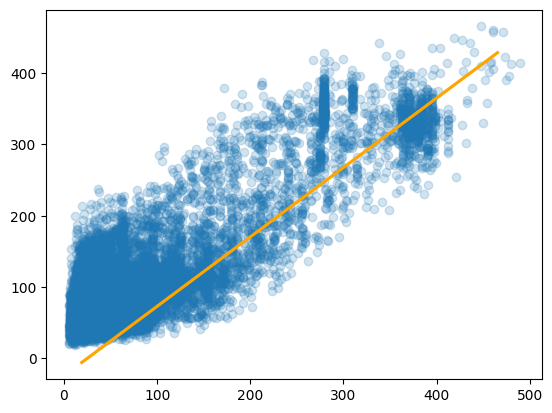

In [67]:
# look observed vs predicted
plt.scatter(yobs, mean_time, alpha=0.2)
# add regression line
sns.regplot(x=mean_time, y=yobs, scatter=False, ci=False, color='orange')